## Lab 7.01 Neural Network Binary Classification
_By Jeff Hale_

This lab uses a small [dataset](https://archive.ics.uci.edu/ml/datasets/heart+Disease) provided by the Cleveland Clinic Foundation for Heart Disease. The goal is to predict whether a patient has heart disease (the *target* column).

We suggest running this lab in [Google Colab](https://colab.research.google.com/). 

Go *File*->*Upload notebook* to upload this notebook to colab.

If you are working in Colab and want to see if you can get a speed boost, set your runtime to *GPU* or *TPU* by going to *Runtime*->*Change runtime type* in the menu above. 

The processor type won't make a big difference with this small dataset and small networks, but it's good to know how to change the processor.

### Get data and then use pandas to load it into a DataFrame

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


Retrieve the csv file containing the heart dataset that ships with TensorFlow.

In [2]:
csv_file = tf.keras.utils.get_file('heart.csv', 'https://storage.googleapis.com/download.tensorflow.org/data/heart.csv')

#### Load the csv file using pandas.

In [3]:
heart = pd.read_csv(csv_file)
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


#### Inspect

In [4]:
heart.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    object 
 13  target    303 non-null    int64  
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [5]:
heart.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [6]:
heart['target'].value_counts()

0    220
1     83
Name: target, dtype: int64

#### Check the value counts of the column that's an object

In [7]:
heart['thal'].value_counts()

normal        168
reversible    115
fixed          18
1               1
2               1
Name: thal, dtype: int64

In [8]:
heart[(heart['thal'] == '1') | (heart['thal'] == '2')]

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
247,59,1,0,164,176,1,0,90,0,1.0,1,2,1,0
252,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


In [9]:
heart = heart[(heart['thal'] != '1') & (heart['thal'] != '2')]

In [10]:
heart['thal'].value_counts()

normal        168
reversible    115
fixed          18
Name: thal, dtype: int64

You could load data into a format for TensorFlow using `tf.data.Dataset`, but these are unwieldly - it's a serious pain to create a validation dataset from a TF dataset. You used to have to make your data into NumPy arrays for TensorFlow. Now you can just keep them as pandas DataFrames!

#### Set up X and y

In [11]:
X = heart.drop(columns='target')
y = heart['target']

In [12]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal


In [13]:
y.head()

0    0
1    1
2    0
3    0
4    0
Name: target, dtype: int64

#### Train-test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=13)

Convert `thal` column to numeric

#### Use scikit-learn to one-hot encode  

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [16]:
X_train_t = ct.fit_transform(X_train)
X_test_t = ct.transform(X_test)

In [17]:
X_train_df = pd.DataFrame(X_train_t, columns=ct.get_feature_names_out())

In [18]:
X_test_df = pd.DataFrame(X_test_t, columns=ct.get_feature_names_out())

#### Set the TensorFlow random seed

In [19]:
# With help from https://www.tensorflow.org/api_docs/python/tf/keras/utils/set_random_seed

tf.keras.utils.set_random_seed(
    1331
)

## Create and train a model

#### Create model structure

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [21]:
model = Sequential()
model.add(Dense(70, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2022-02-03 14:57:36.278263: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Compile

In [22]:
# Using help from the docs to get metrics right
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

#### Make an EarlyStopping callback

In [23]:
# With help from tensorflow documentation
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

#### Fit the model

In [24]:
history = model.fit(
    X_train_df,
    y_train,
    validation_data=(X_test_df, y_test),
    epochs=100,
    callbacks=callback
)

Epoch 1/100
8/8 [==============================] - 1s 52ms/step - loss: 6.5881 - accuracy: 0.3956 - recall: 0.6613 - precision: 0.2628 - val_loss: 3.5217 - val_accuracy: 0.7237 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 0s 4ms/step - loss: 4.0185 - accuracy: 0.7244 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 3.6304 - val_accuracy: 0.7237 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 0s 3ms/step - loss: 2.0806 - accuracy: 0.7200 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6790 - val_accuracy: 0.6447 - val_recall: 0.1905 - val_precision: 0.2857
Epoch 4/100
8/8 [==============================] - 0s 3ms/step - loss: 0.6376 - accuracy: 0.7067 - recall: 0.4677 - precision: 0.4677 - val_loss: 0.6047 - val_accuracy: 0.6711 - val_recall: 0.1429 - val_precision: 0.3000
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.5737 - acc

#### Plot model performance on the validation data (accuracy, recall, and precision)

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'precision', 'val_loss', 'val_accuracy', 'val_recall', 'val_precision'])

''

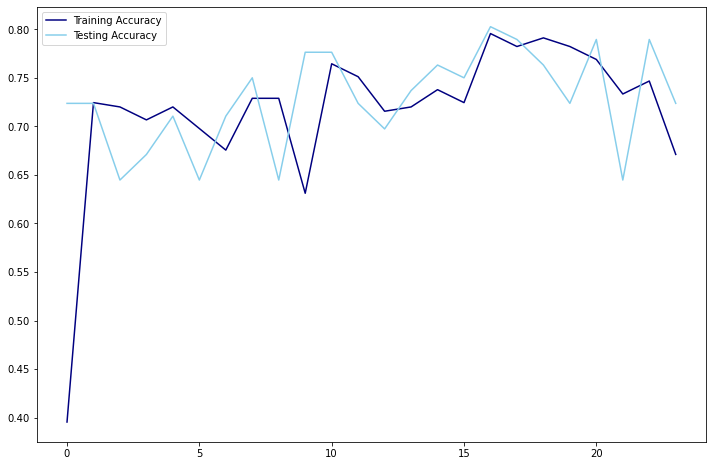

In [26]:
# With help from regularization lesson
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']
train_recall = history.history['recall']
test_recall = history.history['val_recall']
train_precision = history.history['precision']
test_precision = history.history['val_precision']

plt.figure(figsize=(12, 8))
plt.plot(train_accuracy, label='Training Accuracy', color='navy')
plt.plot(test_accuracy, label='Testing Accuracy', color='skyblue')
# plt.plot(train_recall, label='Training Recall', color='darkred')
# plt.plot(test_recall, label='Testing Recall', color='pink')
# plt.plot(train_precision, label='Training Precision', color='green')
# plt.plot(test_precision, label='Testing Precision', color='lightgreen')
plt.legend()
;

#### Save model

In [27]:
model.save('./first_model')

2022-02-03 14:57:39.527867: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./first_model/assets


#### Load model

In [28]:
reloaded_model = tf.keras.models.load_model('./first_model')

#### Evaluate on test set 

In [29]:
reloaded_model.evaluate(X_test_df, y_test)

3/3 [==============================] - 1s 7ms/step - loss: 0.9984 - accuracy: 0.7237 - recall: 0.0000e+00 - precision: 0.0000e+00


[0.998429536819458, 0.7236841917037964, 0.0, 0.0]

#### X_test predictions

In [30]:
reloaded_model.predict(X_test_df)

array([[0.01311749],
       [0.00156653],
       [0.01898286],
       [0.00727931],
       [0.10743782],
       [0.00136101],
       [0.00714552],
       [0.01051176],
       [0.00128067],
       [0.05094802],
       [0.00757623],
       [0.00673684],
       [0.04699314],
       [0.12467539],
       [0.01259306],
       [0.00113311],
       [0.00071701],
       [0.00396904],
       [0.00070581],
       [0.00898319],
       [0.06060612],
       [0.00242817],
       [0.00506264],
       [0.0067915 ],
       [0.01172307],
       [0.00120971],
       [0.0028066 ],
       [0.00022197],
       [0.00801665],
       [0.00130031],
       [0.00093627],
       [0.03466448],
       [0.0153684 ],
       [0.00061101],
       [0.00054115],
       [0.02537239],
       [0.00812691],
       [0.00803009],
       [0.01596969],
       [0.00074145],
       [0.02872521],
       [0.0676856 ],
       [0.12994447],
       [0.00201041],
       [0.00217316],
       [0.00021011],
       [0.00429487],
       [0.004

#### What do those look like?

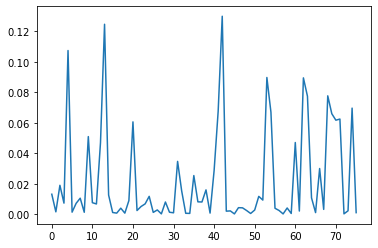

In [31]:
plt.plot(reloaded_model.predict(X_test_df))

#### How is the model performing? 
Let's look at the confusion matrix using TF.

In [34]:
# Using the docs
tf.compat.v1.confusion_matrix(
    labels=y_test,
    predictions=reloaded_model.predict(X_test_df),
    
)

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[55,  0],
       [21,  0]], dtype=int32)>

Or just use sklearn's confusion matrix. 

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

In [38]:
ConfusionMatrixDisplay(tf.compat.v1.confusion_matrix(
    labels=y_test,
    predictions=reloaded_model.predict(X_test_df),
    
))

#### Evaluate with other metrics

### Make a null model

## Can you make a better model?

Change the model architecture and see if you can make a better model. Add nodes, dense layers, and dropout layers.

#### Save your best model. 


### Compare with other algorithms
Compare your best neural net model to scikit-learn's LogisticRegression, SVM, and GradientBoostingClassifier. Hyperparameter search for good options.

#### Which model performs best in terms of F1 Score?

#### What does the F1 Score mean in a few words?

#### Which model would you recommend for use? Why?


#### Download your notebook and put it in your submission folder. 🎉